# Use pytorch to predict Log TPM data, keep BLAST connected components in same split
A relatively simple task: determine from the promoter if the gene should be generally highly or generally lowly expressed. If we can't do this, then we should not expect the model to do anything more complicated. 

At one point, we realized that many promoters share very high sequence similarity with others, some of which have higly correlated expression. To prevent the model from having train/val leakage, we implement a split to keep promoters in the same BLAST connected component in the same train/val/test split

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load 5G logTPM data

In [5]:
cond_file = 'data/conditions_to_include_20221031.txt'
with open(cond_file, 'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum',
 'LanzaTech',
 'aa3_KO',
 'crotonic_acid',
 'CH4_500ppm',
 'CH4_1000ppm']

In [6]:
sample_file = 'data/sample2condition_20221031.txt'
with open(sample_file, 'r') as f:
    samp2cond = dict([x.strip().split('\t') for x in f.readlines()])
    
samp2cond.keys()

dict_keys(['5GB1_ferm_Ack_QC_tpm', '5GB1_ferm_WT_QC_tpm', '5GB1_FM03_TR1_QC_tpm', '5GB1_FM03_TR2_QC_tpm', '5GB1_FM11_TR1_QC_tpm', '5GB1_FM11_TR2_QC_tpm', '5GB1_FM12_TR1_tpm', '5GB1_FM12_TR1_QC_tpm', '5GB1_FM12_TR2_tpm', '5GB1_FM12_TR2_QC_tpm', '5GB1_FM14_TR1_tpm', '5GB1_FM14_TR1_QC_tpm', '5GB1_FM14_TR2_tpm', '5GB1_FM14_TR2_QC_tpm', '5GB1_FM18_TR1_QC_tpm', '5GB1_FM18_TR2_tpm', '5GB1_FM18_TR2_QC_tpm', '5GB1_FM18_TR3_tpm', '5GB1_FM18_TR3_QC_tpm', '5GB1_FM19_TR1_tpm', '5GB1_FM19_TR1_QC_tpm', '5GB1_FM19_TR1_UW_tpm', '5GB1_FM19_TR3_tpm', '5GB1_FM19_TR3_QC_tpm', '5GB1_FM20_TR1_QC_tpm', '5GB1_FM20_TR2_QC_tpm', '5GB1_FM20_TR3_tpm', '5GB1_FM20_TR3_QC_tpm', '5GB1_FM20_TR3_UW_tpm', '5GB1_FM21_TR1_tpm', '5GB1_FM21_TR1_QC_tpm', '5GB1_FM21_TR2_tpm', '5GB1_FM21_TR2_QC_tpm', '5GB1_FM21_TR2_UW_tpm', '5GB1_FM22_TR1_tpm', '5GB1_FM22_TR1_QC_tpm', '5GB1_FM22_TR3_tpm', '5GB1_FM22_TR3_QC_tpm', '5GB1_FM22_TR3_UW_tpm', '5GB1_FM23_TR3_tpm', '5GB1_FM23_TR3_QC_tpm', '5GB1_FM34_T0_TR1_QC_tpm', '5GB1_FM34_T3_TR3_QC_

In [7]:
samples = [x for x in samp2cond if samp2cond[x] in conds]
print(len(samples))
print(len(samp2cond))

# samples does not include a sample who's cond is not in conds

90
102


In [8]:
#locus_info_filename = 'data/locus2info.tsv'
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t').fillna("")
display(locus_info_df.head())
locus2info = u.make_info_dict(locus_info_df)

tpm_data_filename = "data/5GB1_tpms_20221031.tsv"
tpm_df = pd.read_csv(tpm_data_filename,sep='\t').fillna("")

display(tpm_df.head())

print(locus2info['EQU24_RS23150'])
display(tpm_df[tpm_df['locus_tag']=='EQU24_RS23150'])

,locus_tag,gene_symbol,product,type
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,CDS
1,EQU24_RS00010,dnaN,DNA polymerase III subunit beta,CDS
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,CDS
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS
4,EQU24_RS00035,,hypothetical protein,CDS


,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,1318,2.920380,...,38.638102,31.867873,30.546267,36.840627,29.198516,35.405768,56.747208,55.734395,46.812595,35.325741
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,dnaN,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,1102,1.600865,...,45.092244,45.889651,34.824076,44.661748,35.864388,45.409001,32.721559,33.467532,34.906928,30.020538
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,1081,1.409423,...,21.362765,20.976809,17.355043,21.854708,18.734014,25.608242,26.409599,23.529439,21.368579,16.896055
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,2416,3.186309,...,57.478160,61.623220,52.941842,63.050677,55.592843,58.631387,48.167231,51.249206,61.811500,54.226180
4,EQU24_RS00035,hypothetical protein,CDS,,NZ_CP035467.1,7350,7734,Derived by automated computational analysis us...,385,8.852007,...,118.910610,106.287739,102.200487,116.972791,105.924563,129.975893,86.942252,83.059104,118.967455,94.451247


{'gene': 'hxlB', 'product': '6-phospho-3-hexuloisomerase', 'type': 'CDS'}


,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm
4183,EQU24_RS23150,6-phospho-3-hexuloisomerase,CDS,hxlB,NZ_CP035467.1,4877125,4877659,Derived by automated computational analysis us...,535,39.344956,...,2365.689931,2769.139632,1243.677654,1770.553275,2378.489135,2178.110269,1520.59018,1588.76192,2084.454046,1961.803703


In [9]:
log_tpm_df = pd.read_csv("data/XY_logTPM_opFilt_20221031.tsv",sep='\t')
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,5.192777,5.969066,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,5.687118,6.581135,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,4.585745,5.439145,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,6.075307,6.562648,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,4.444783,4.238753,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,10.625349,10.234527,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,10.624571,10.255792,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,10.655103,10.317302,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,4.899572,5.240644,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353


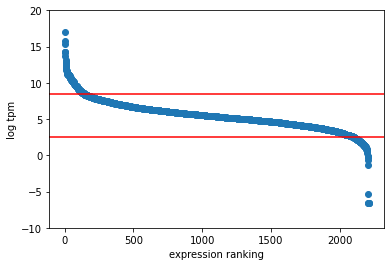

In [10]:
hicu = sorted(log_tpm_df['highCu'].values, reverse=True)

x,y = list(zip(*enumerate(hicu)))
plt.scatter(x,y)
#plt.yscale('log')
plt.ylim(-10,20)
plt.axhline(8.5,c='red')
plt.axhline(2.5,c='red')
plt.xlabel('expression ranking')
plt.ylabel('log tpm')
plt.show()

In [11]:
uppert = 8.5
lowert = 2.5

hi_hicu = log_tpm_df[log_tpm_df['highCu']>uppert]
med_hicu = log_tpm_df[log_tpm_df['highCu'].between(lowert, uppert)]
low_hicu = log_tpm_df[log_tpm_df['highCu']<lowert]

In [12]:
print(hi_hicu.shape)
print(med_hicu.shape)
print(low_hicu.shape)

(143, 20)
(1959, 20)
(109, 20)


In [13]:
# calculate the mean across all samples, and the log of that number
tpm_df['overall_mean_tpm'] = tpm_df.apply(lambda row: np.mean(row[samples]) ,axis=1)
tpm_df['log_overall_mean_tpm'] = tpm_df['overall_mean_tpm'].apply(lambda x: np.log2(x))
tpm_df

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm,overall_mean_tpm,log_overall_mean_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,1318,2.920380,...,30.546267,36.840627,29.198516,35.405768,56.747208,55.734395,46.812595,35.325741,36.622138,5.194644
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,dnaN,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,1102,1.600865,...,34.824076,44.661748,35.864388,45.409001,32.721559,33.467532,34.906928,30.020538,46.466629,5.538123
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,1081,1.409423,...,17.355043,21.854708,18.734014,25.608242,26.409599,23.529439,21.368579,16.896055,24.181343,4.595822
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,2416,3.186309,...,52.941842,63.050677,55.592843,58.631387,48.167231,51.249206,61.811500,54.226180,52.516137,5.714689
4,EQU24_RS00035,hypothetical protein,CDS,,NZ_CP035467.1,7350,7734,Derived by automated computational analysis us...,385,8.852007,...,102.200487,116.972791,105.924563,129.975893,86.942252,83.059104,118.967455,94.451247,72.804010,6.185946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,EQU24_RS23155,3-hexulose-6-phosphate synthase,CDS,hxlA,NZ_CP035467.1,4877662,4878310,Derived by automated computational analysis us...,649,54.488824,...,2972.807778,3975.569016,4832.782004,5503.508261,2093.320771,2189.062660,2612.122268,2556.194919,2323.469042,11.182065
4185,EQU24_RS23160,6-phospho-3-hexuloisomerase,CDS,hxlB,NZ_CP035467.1,4882314,4882848,Derived by automated computational analysis us...,535,39.120128,...,1240.700959,1765.269056,2365.333503,2142.160596,1521.529928,1598.613630,2081.876627,1962.755769,1833.953899,10.840742
4186,EQU24_RS23165,3-hexulose-6-phosphate synthase,CDS,hxlA,NZ_CP035467.1,4882851,4883499,Derived by automated computational analysis us...,649,49.546527,...,2831.473500,3738.866442,4470.981143,5103.421732,1613.939517,1649.074688,2003.711339,1940.573398,2285.823809,11.158498
4187,EQU24_RS23170,transposase,CDS,,NZ_CP035467.1,4918898,4919603,Derived by automated computational analysis us...,706,5.792673,...,23.052263,30.934037,35.897452,41.177703,32.119364,25.035217,28.898838,26.694263,36.482158,5.189119


In [14]:
# # Spot check a few:
# pmoc_row = tpm_df[tpm_df['locus_tag']=='EQU24_RS19315']
# psamps = pmoc_row[samples].values
# np.mean(psamps)

In [15]:
# pmoc_row['overall_mean_tpm']

In [16]:
# # Use one of the other XY dfs to get the upstream regions
# XY_cond_df = pd.read_csv('data/XY_TPM_opFilt_20221031.tsv',sep='\t')
# display(XY_cond_df.head())
# loc2seq = dict([(x,z) for (x,z) in XY_cond_df[['locus_tag','upstream_region']].values])

# print(locus2info['EQU24_RS19315'])
# print(loc2seq['EQU24_RS19315'])

# print(locus2info['EQU24_RS23145'])
# print(loc2seq['EQU24_RS23145'])

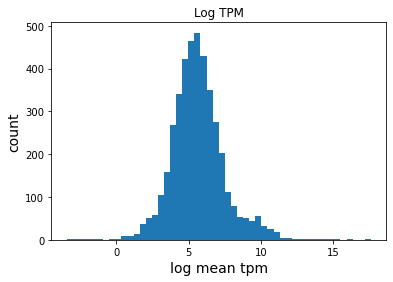

In [17]:
# Log TPM - mean log tpm column
plt.hist(tpm_df['log_overall_mean_tpm'].values,bins=50)
plt.xlabel("log mean tpm",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

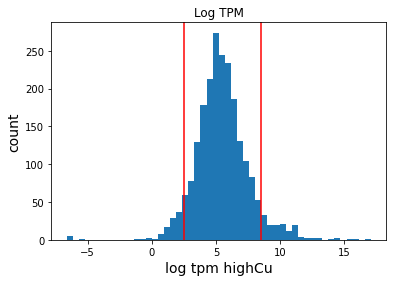

In [18]:
# Log TPM - highCu log tpm column
plt.hist(log_tpm_df['highCu'].values,bins=50)
plt.xlabel("log tpm highCu",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.axvline(uppert,c='red')
plt.axvline(lowert,c='red')
plt.title("Log TPM")
plt.show()

In [19]:
# assemble xy df
# XY_df = XY_cond_df[['locus_tag','upstream_region']]
# XY_df = pd.merge(XY_df,tpm_df[['locus_tag','log_overall_mean_tpm']],on='locus_tag',how='left')
# XY_df

In [20]:
# Log TPM - mean log tpm column - Op Filt
# plt.hist(XY_df['log_overall_mean_tpm'].values,bins=50)
# plt.xlabel("log mean tpm",fontsize=14)
# plt.ylabel("count",fontsize=14)
# plt.title("Log TPM")
# plt.show()

### *This is the distribution I'm trying to predict*

## Add Null Seq Column

In [21]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

log_tpm_df['shuffled_seq'] = log_tpm_df['upstream_region'].apply(lambda x: shuffle_seq(x))
log_tpm_df[['upstream_region','shuffled_seq']]

,upstream_region,shuffled_seq
0,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...
1,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...
2,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...
3,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...
4,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...
...,...,...
2206,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...
2207,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...
2208,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...
2209,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...


## Modified Train/test split

In [22]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit

In [23]:
# load connected component map
loc2cc = dict(pd.read_csv('data/loc2ccid_aln200_pident90.tsv',sep='\t').values)
loc2cc

{'EQU24_RS00080': 0,
 'EQU24_RS00085': 0,
 'EQU24_RS00165': 1,
 'EQU24_RS00175': 2,
 'EQU24_RS00180': 2,
 'EQU24_RS00210': 3,
 'EQU24_RS00225': 4,
 'EQU24_RS00230': 4,
 'EQU24_RS00245': 5,
 'EQU24_RS00250': 5,
 'EQU24_RS00255': 6,
 'EQU24_RS00260': 6,
 'EQU24_RS00275': 7,
 'EQU24_RS00625': 8,
 'EQU24_RS00640': 9,
 'EQU24_RS00645': 10,
 'EQU24_RS00650': 11,
 'EQU24_RS00690': 12,
 'EQU24_RS00695': 12,
 'EQU24_RS00845': 13,
 'EQU24_RS00850': 13,
 'EQU24_RS00860': 14,
 'EQU24_RS00865': 14,
 'EQU24_RS00930': 11,
 'EQU24_RS01010': 15,
 'EQU24_RS01015': 15,
 'EQU24_RS01030': 1,
 'EQU24_RS01060': 16,
 'EQU24_RS01125': 17,
 'EQU24_RS01255': 18,
 'EQU24_RS01260': 18,
 'EQU24_RS01385': 19,
 'EQU24_RS01390': 20,
 'EQU24_RS01395': 20,
 'EQU24_RS01425': 21,
 'EQU24_RS01430': 21,
 'EQU24_RS01475': 22,
 'EQU24_RS01480': 22,
 'EQU24_RS01550': 23,
 'EQU24_RS01560': 23,
 'EQU24_RS01630': 24,
 'EQU24_RS01635': 24,
 'EQU24_RS01795': 25,
 'EQU24_RS01810': 26,
 'EQU24_RS01815': 27,
 'EQU24_RS01820': 27,
 'EQ

In [25]:
max(loc2cc.values())

177

In [30]:
def get_ccid(locus):
    '''
    If the locus is not yet in the cc dict, give it the 
    id of +1 of the max value in the dict. Add it to 
    the dict so the next id increments.
    '''
    new_id = max(loc2cc.values())+1
    if locus in loc2cc:
        return loc2cc[locus]
    else:
        loc2cc[locus] = new_id
        return new_id

In [29]:
log_tpm_df['cc_id'] = log_tpm_df['locus_tag'].apply(lambda x: get_ccid(x))
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...,180
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...,177
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...,171
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [31]:
gss = GroupShuffleSplit(n_splits=3, train_size=.7, random_state=42)

In [32]:
groups = log_tpm_df['cc_id'].values
gss.split(log_tpm_df,groups=groups)

<generator object BaseShuffleSplit.split at 0x7f6f3c367450>

In [33]:
for i, (train_index, test_index) in enumerate(gss.split(log_tpm_df, groups=groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")

Fold 0:
  Train: index=[   0    1    2 ... 2208 2209 2210], group=[ 178  179  180 ...  171 1962 1963]
  Test:  index=[   4    8    9   11   12   15   27   29   31   33   34   38   45   46
   47   57   61   67   76   78   82   85   86   90   93   94   95   99
  101  104  106  110  112  116  117  123  124  125  126  127  128  146
  149  150  151  154  159  162  164  167  169  170  171  173  174  175
  184  192  194  201  202  203  204  206  211  214  216  222  223  224
  225  226  233  237  238  239  243  246  250  251  254  257  258  259
  269  270  273  279  286  289  292  294  295  296  297  301  303  306
  307  310  315  318  319  324  326  346  352  362  364  365  371  378
  379  380  381  382  383  385  386  391  392  393  394  400  404  406
  409  410  417  418  425  429  430  437  438  440  441  443  445  447
  450  456  457  462  466  468  469  471  472  473  479  486  492  494
  497  498  501  504  505  506  507  509  511  513  514  516  521  523
  524  527  534  535  536  540 

In [34]:
trainz = log_tpm_df.loc[train_index]
testz = log_tpm_df.loc[test_index]

In [35]:
trainz_vc = trainz['cc_id'].value_counts().reset_index()
testz_vc = testz['cc_id'].value_counts().reset_index()
trainz_vc

,index,cc_id
0,26,8
1,1,5
2,86,4
3,169,4
4,42,4
...,...,...
1369,756,1
1370,755,1
1371,753,1
1372,752,1


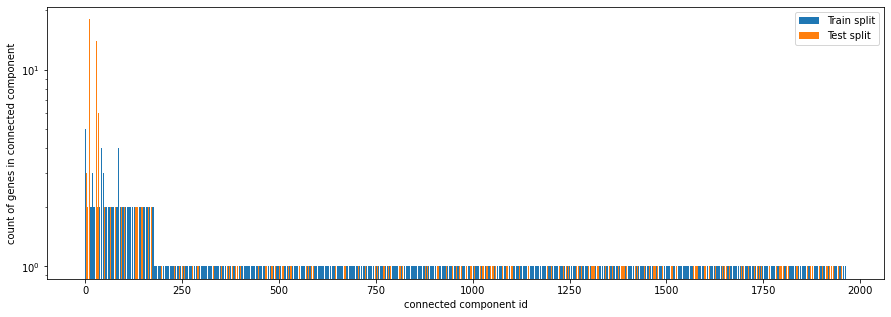

In [36]:
plt.figure(figsize=(15,5))
plt.bar(trainz_vc['index'],trainz_vc['cc_id'],label="Train split")
plt.bar(testz_vc['index'],testz_vc['cc_id'],label="Test split")
plt.yscale('log')
plt.xlabel("connected component id")
plt.ylabel("count of genes in connected component")
plt.legend()
plt.show()

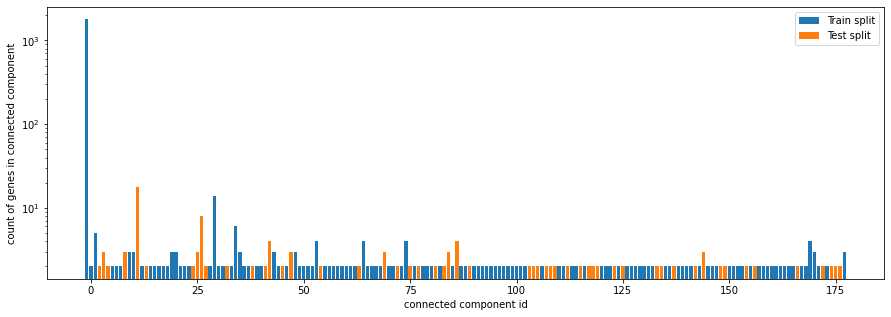

In [77]:
plt.figure(figsize=(15,5))
plt.bar(trainz_vc['index'],trainz_vc['cc_id'],label="Train split")
plt.bar(testz_vc['index'],testz_vc['cc_id'],label="Test split")
plt.yscale('log')
plt.xlabel("connected component id")
plt.ylabel("count of genes in connected component")
plt.legend()
plt.show()

In [48]:
# loop this back into train/test split!

In [89]:
tra, tes = next(gss.split(log_tpm_df,groups=groups))

In [40]:
def group_conscious_train_test_split(df,group_col,split_frac=0.8,make_plot=False):
    '''
    given a dataframe of examples with a column containing a group id, 
    split the df into train and test but make sure all examples
    of the same group id end up in the same split.
    '''
    df = df.reset_index()
    
    gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    groups = df[group_col].values
    
    train_idxs,test_idxs = next(gss.split(df,groups=groups))
    
    train_df = df.loc[train_idxs]
    test_df = df.loc[test_idxs]
    
    if make_plot:
        train_vc = train_df['cc_id'].value_counts().reset_index()
        test_vc = test_df['cc_id'].value_counts().reset_index()
        
        plt.figure(figsize=(15,5))
        plt.bar(train_vc['index'],train_vc['cc_id'],label="Train split")
        plt.bar(test_vc['index'],test_vc['cc_id'],label="Test split")
        plt.yscale('log')
        plt.xlabel("connected component id")
        plt.ylabel("count of genes in connected component")
        plt.legend()
        plt.show()
    
    return train_df, test_df

# def ccid_conscious_train_test_split(df,cc_col='cc_id',cc_default=-1,split_frac=0.8,make_plot=False):
#     '''
#     given a dataframe of examples with a column containing a 'cc_id', 
#     split the df into train and test but make sure all examples
#     in the test set are not in any promoter connected components.
#     '''
#     non_cc_df = df[df[cc_col] == cc_default]
#     cc_df = df[df[cc_col] != cc_default]
#     if cc_df.shape[0] == 0:
#         raise ValueError("No connected components in df!")

#     # number of rows in a promoter cc (cc_id != -1)
#     cc_row_count = cc_df.shape[0]
#     total_rows = df.shape[0]
#     cc_proportion = cc_row_count/total_rows
    
#     if cc_proportion > split_frac:
#         raise ValueError("The number of promoters in a connected component is more than the split fraction... not enough default non-cc promoters for the test set!")
    
#     # all of the cc promoters are being shoved into the train set, so they fill
#     # up some proportion of the split. Adjust the split frac to randomly split 
#     # the remaining default non-cc promoters
#     adj_split_frac = split_frac - cc_proportion
#     print("Adjusted split frac = ",adj_split_frac)
    
#     part_train_df, test_df = tu.quick_split(non_cc_df,split_frac=adj_split_frac)
               
#     full_train_df = pd.concat([part_train_df,cc_df])
    
#     return full_train_df, test_df
    

In [98]:
full_train_df,test_df = ccid_conscious_train_test_split(log_tpm_df)

Adjusted split frac =  0.6077792853912257


In [ ]:

# FINISH THIS!
def make_group_split_plot():
    if make_plot:
        train_vc = train_df['cc_id'].value_counts().reset_index()
        test_vc = test_df['cc_id'].value_counts().reset_index()
        
        plt.figure(figsize=(15,5))
        plt.bar(train_vc['index'],train_vc['cc_id'],label="Train split")
        plt.bar(test_vc['index'],test_vc['cc_id'],label="Test split")
        plt.yscale('log')
        plt.xlabel("connected component id")
        plt.ylabel("count of genes in connected component")
        plt.legend()
        plt.show()

In [38]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

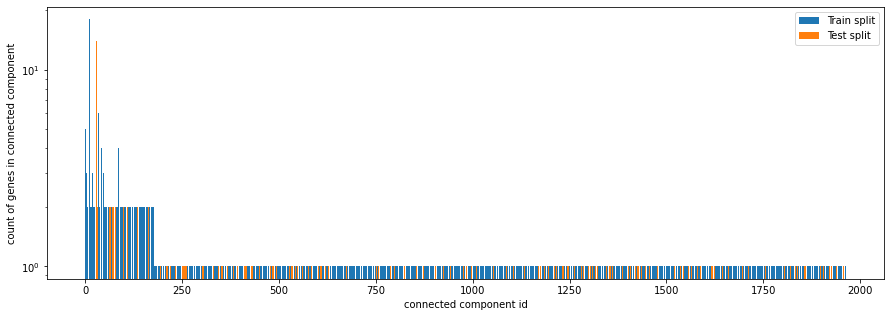

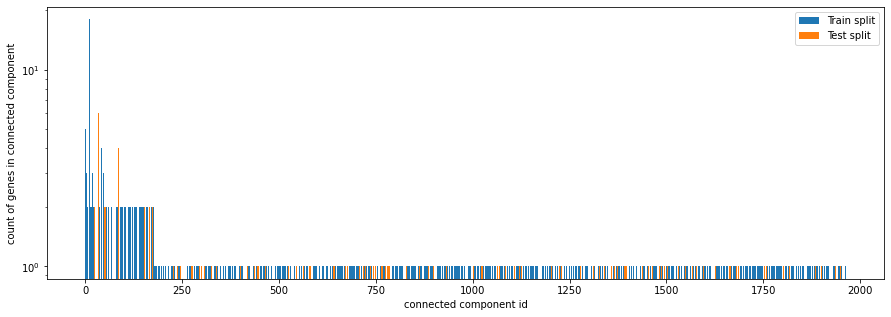

(1772, 23)
(439, 23)
(1422, 24)
(350, 24)


In [41]:
# LOG
#full_train_df,test_df = tu.quick_split(XY_df)
# full_train_df,test_df = tu.quick_split(log_tpm_df)
# train_df, val_df = tu.quick_split(full_train_df)

# Group conscious split
full_train_df,test_df = group_conscious_train_test_split(log_tpm_df,'cc_id',make_plot=True)
train_df, val_df = group_conscious_train_test_split(full_train_df,'cc_id',make_plot=True)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

In [42]:
full_train_df

,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
2,2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...,180
3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
2207,2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...,177
2208,2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...,171
2209,2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [43]:
train_df

,level_0,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
2,2,2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...,180
3,3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
4,4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,2206,2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
1768,2207,2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...,177
1769,2208,2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...,171
1770,2209,2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [49]:
# confirm that there are no cc_ids that overlap between full_train and test and between train and val
ft_set = set(full_train_df['cc_id'].values)
te_set = set(test_df['cc_id'].values)
tr_set = set(train_df['cc_id'].values)
va_set = set(val_df['cc_id'].values)

print("Full train vs test: ", ft_set.intersection(te_set))
print("train vs val: ", tr_set.intersection(va_set))
print("full_train vs va: ", ft_set.intersection(va_set))

Full train vs test:  set()
train vs val:  set()
full_train vs va:  {15, 24, 33, 34, 36, 50, 52, 58, 61, 72, 77, 82, 84, 86, 89, 92, 95, 97, 126, 129, 136, 144, 152, 153, 157, 166, 174, 199, 200, 206, 208, 214, 216, 227, 228, 238, 246, 248, 253, 274, 277, 288, 294, 295, 299, 300, 308, 311, 326, 328, 339, 340, 345, 346, 348, 369, 378, 379, 386, 389, 392, 401, 409, 419, 420, 430, 435, 437, 445, 446, 447, 448, 449, 465, 466, 470, 474, 487, 489, 490, 503, 515, 523, 525, 531, 545, 547, 549, 550, 556, 557, 563, 564, 579, 581, 601, 624, 626, 632, 641, 642, 643, 648, 655, 662, 663, 672, 677, 681, 683, 686, 688, 697, 708, 717, 718, 723, 724, 728, 733, 736, 740, 744, 749, 753, 763, 765, 767, 775, 780, 783, 785, 790, 799, 805, 809, 829, 851, 853, 861, 863, 879, 880, 886, 893, 897, 899, 932, 938, 941, 942, 952, 955, 964, 965, 981, 988, 1002, 1003, 1014, 1019, 1023, 1024, 1025, 1026, 1032, 1060, 1064, 1066, 1069, 1070, 1083, 1085, 1104, 1108, 1115, 1121, 1126, 1129, 1135, 1140, 1148, 1155, 1156, 116

In [44]:
split_dfs = {
    'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

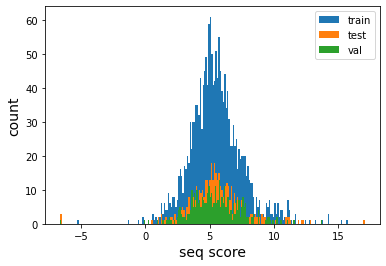

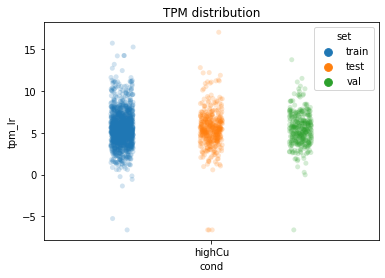

In [45]:
plot_train_test_hist(full_train_df, test_df,score_col='highCu',bins=200,val_df=val_df)
view_train_test_dist(train_df, test_df,["highCu"],"TPM",val_df=val_df)

# split the genes, show dist of logTPM of HighCu column
# plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='log_overall_mean_tpm',bins=200)
# view_train_test_dist(train_df, test_df,["log_overall_mean_tpm"],"TPM",val_df=val_df)

## Load 5G seqs into data loaders

In [50]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

# _RUNNING REGULAR SEQS_

In [51]:
# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col='upstream_region',
    #seq_col='shuffled_seq',
    target_col='highCu'
    #target_col='log_overall_mean_tpm'
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    #seq_col='shuffled_seq',
    target_col='highCu'
    #target_col='log_overall_mean_tpm'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [52]:
for xb,yb, in ohe_val_dl:
    print(xb.shape)
    print(yb.shape)
    print()

torch.Size([128, 300, 4])
torch.Size([128, 1])

torch.Size([128, 300, 4])
torch.Size([128, 1])

torch.Size([94, 300, 4])
torch.Size([94, 1])



In [53]:
ohe_val_dl.batch_size

128

## run model 

In [54]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            1, # num tasks
        )
    model.to(DEVICE)

    loss_func = torch.nn.MSELoss() 
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # comment out to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [55]:
def parity_pred_by_split(model_name,
                         device,
                         locus_col='locus_tag',
                         seq_col='seq',
                         target_col="score",
                         splits=['train','val']
                        ):
    '''
    Given a trained model, get the model's predictions on each split
    of the data and create parity plots of the y predictions vs actual ys
    '''
    # init subplots
    fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
    pred_dfs = {}
    
    def parity_plot(model_title,ytrue,ypred,rigid=True):
        axs[i].scatter(ytrue, ypred, alpha=0.2)

        r2 = r2_score(ytrue,ypred)
        pr = pearsonr(ytrue,ypred)[0]
        sp = spearmanr(ytrue,ypred).correlation

        # y=x line
        xpoints = ypoints = plt.xlim()
        if rigid:
            axs[i].set_ylim(min(xpoints),max(xpoints)) 
        axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
        axs[i].set_xlabel("Actual Score",fontsize=14)
        axs[i].set_ylabel("Predicted Score",fontsize=14)
    
    for i,split in enumerate(splits):
        print(f"{split} split")
        df = split_dfs[split]
        loci = df[locus_col].values
        seqs = list(df[seq_col].values)        
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
        labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    #dfs = {} # key: model name, value: parity_df
    
        # initialize prediction df with just locus col
        pred_df = df[[locus_col]]
        pred_df['truth'] = df[target_col]
        print(f"Running {model_name}")
        
        model = model_res[model_name]['model']
        # ask model to predict on seqs
        preds = model(ohe_seqs.float()).tolist()
        # preds is a tensor converted to a list, 
        # single elements returned as a list, hence x[0]
        pred_df['pred'] = [x[0] for x in preds]
        
        # do I want the result dfs? revise if so
        #dfs[model_name] = pred_df
        
        # plot stuff
        ytrue = pred_df['truth'].values
        ypred = pred_df['pred'].values
        
        #plt.subplot(len(splits),i+1,1)
        model_title = split
        parity_plot(model_title,ytrue,ypred)
        
        # save predictions
        pred_dfs[split] = pred_df
    
    
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return pred_dfs

In [56]:
model_res = {}
seq_len = len(train_df['upstream_region'].values[0])

E:223 | train loss:1.820 | val loss: 4.678:   4%|▍         | 223/5000 [00:14<03:57, 20.14it/s] 

EarlyStopping counter: 125 out of 500


E:348 | train loss:0.987 | val loss: 4.914:   7%|▋         | 349/5000 [00:20<03:50, 20.21it/s]

EarlyStopping counter: 250 out of 500


E:473 | train loss:0.655 | val loss: 5.030:   9%|▉         | 472/5000 [00:26<03:44, 20.14it/s]

EarlyStopping counter: 375 out of 500


E:594 | train loss:0.543 | val loss: 5.136:  12%|█▏        | 594/5000 [00:32<04:03, 18.12it/s]


EarlyStopping counter: 500 out of 500
Early stopping


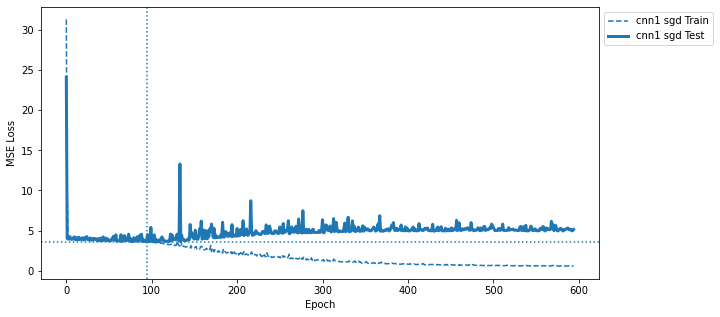

In [57]:
cnn1_name = 'cnn1 sgd'
#cnn1_name = 'cnn1 sgd shuff'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn1 sgd
val split
Running cnn1 sgd
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn1 sgd


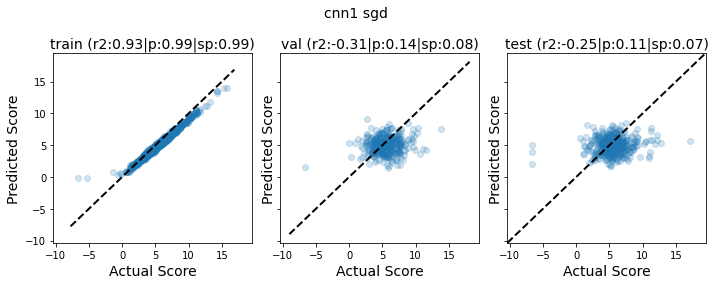

In [58]:
pred_dfs = parity_pred_by_split(cnn1_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:775 | train loss:0.161 | val loss: 4.333:  16%|█▌        | 776/5000 [00:41<03:44, 18.81it/s]

EarlyStopping counter: 750 out of 3000


E:1525 | train loss:0.093 | val loss: 4.425:  31%|███       | 1526/5000 [01:21<03:05, 18.69it/s]

EarlyStopping counter: 1500 out of 3000


E:2275 | train loss:0.082 | val loss: 4.515:  46%|████▌     | 2276/5000 [02:01<02:25, 18.74it/s]

EarlyStopping counter: 2250 out of 3000


E:3022 | train loss:0.070 | val loss: 4.354:  60%|██████    | 3022/5000 [02:41<01:46, 18.66it/s]


EarlyStopping counter: 3000 out of 3000
Early stopping


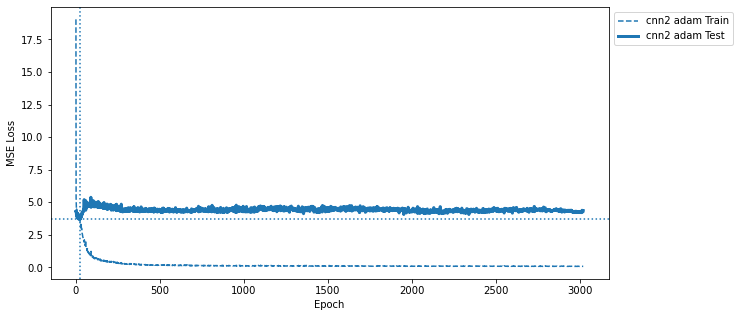

In [59]:
cnn2_name = 'cnn2 adam'
#cnn2_name = 'cnn2 adam shuff'

model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn2 adam
val split
Running cnn2 adam
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam


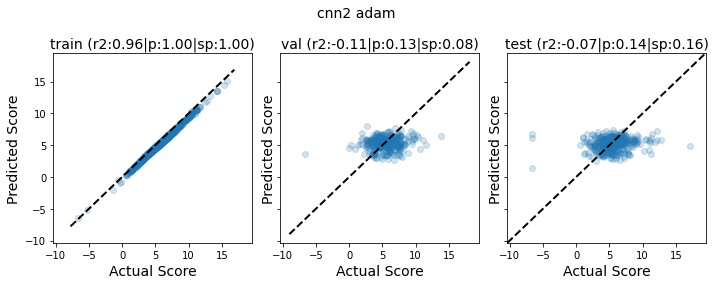

In [60]:
pred_dfs = parity_pred_by_split(cnn2_name,
                                DEVICE,
                                seq_col='upstream_region',
                                #seq_col='shuffled_seq',
                                #target_col='log_overall_mean_tpm',
                                target_col='highCu',
                                splits=['train','val','test']
                    )

E:914 | train loss:0.845 | val loss: 5.390:  18%|█▊        | 914/5000 [00:49<03:38, 18.70it/s]

EarlyStopping counter: 750 out of 3000


E:1664 | train loss:0.407 | val loss: 5.044:  33%|███▎      | 1664/5000 [01:29<02:59, 18.57it/s]

EarlyStopping counter: 1500 out of 3000


E:2414 | train loss:0.327 | val loss: 4.787:  48%|████▊     | 2414/5000 [02:09<02:19, 18.55it/s]

EarlyStopping counter: 2250 out of 3000


E:3161 | train loss:0.307 | val loss: 4.686:  63%|██████▎   | 3161/5000 [02:50<01:38, 18.58it/s]


EarlyStopping counter: 3000 out of 3000
Early stopping


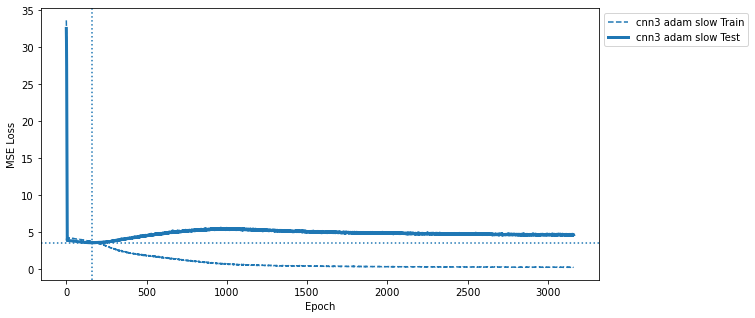

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn3 adam slow
val split
Running cnn3 adam slow
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn3 adam slow


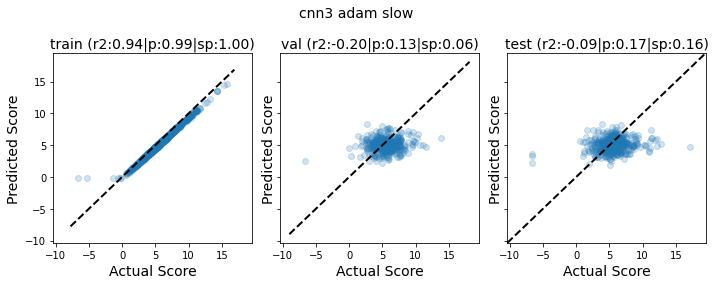

In [61]:
cnn3_name = 'cnn3 adam slow'
#cnn3_name = 'cnn3 adam slow shuff'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

cnn3_pred_dfs = parity_pred_by_split(cnn3_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

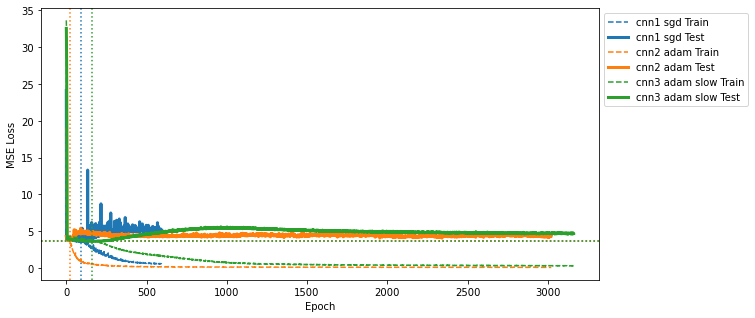

In [62]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

### ok so overfitting is happening... move away from this with data aug

# Data Augmentation

In [63]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.1):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G'],
        'N':['N'] # no signal, just ignore
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])



In [64]:
n=10
aug_train_df = augment_mutate(train_df,n,seq_col='upstream_region')
#aug_train_df = augment_mutate(train_df,n,seq_col='shuffled_seq')

In [65]:
aug_train_df

,level_0,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,...,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id,set,seq_version
0,0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,...,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178,train,0
1,1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,...,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179,train,0
2,2,2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,...,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...,180,train,0
3,3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,...,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181,train,0
4,4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,...,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14215,2210,2210,4188,EQU24_RS23175,GACAACAATTGAACATGATTCGTCCTCGGAACGAACGCGTAAAACT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,0.974049,2.469011,1.313992,2.970741,0.101289,-0.419729,CCGGTGAGAATTCACAGCTCTTACCGGGCAGAAGACGCTCTGTGCT...,1963,train,6
14216,2210,2210,4188,EQU24_RS23175,GACTAAAAATGAACATGTTTCGTCAGCTGAACGAATGCGTAAAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,0.974049,2.469011,1.313992,2.970741,0.101289,-0.419729,CCGGTGAGAATTCACAGCTCTTACCGGGCAGAAGACGCTCTGTGCT...,1963,train,7
14217,2210,2210,4188,EQU24_RS23175,GACTACAAATGAACATGATGCGTCATCTGACCGATAGCGTACAGCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,0.974049,2.469011,1.313992,2.970741,0.101289,-0.419729,CCGGTGAGAATTCACAGCTCTTACCGGGCAGAAGACGCTCTGTGCT...,1963,train,8
14218,2210,2210,4188,EQU24_RS23175,AACAACAAATGAACATGGTTCGTCATCTGAAAGAAAGCGTAAACCT...,2.986357,2.730569,2.235119,2.911585,2.795251,...,0.974049,2.469011,1.313992,2.970741,0.101289,-0.419729,CCGGTGAGAATTCACAGCTCTTACCGGGCAGAAGACGCTCTGTGCT...,1963,train,9


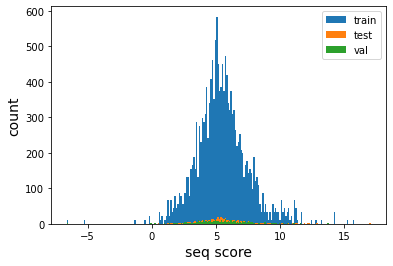

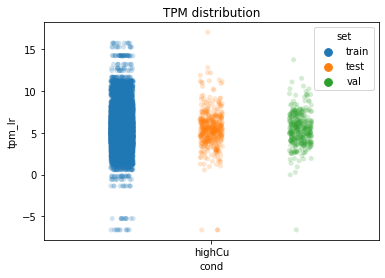

In [66]:
plot_train_test_hist(aug_train_df, test_df,score_col='highCu',bins=200,val_df=val_df)
view_train_test_dist(aug_train_df, test_df,["highCu"],"TPM",val_df=val_df)

In [67]:
# Dfs from further spliting train into train and val
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    #seq_col='shuffled_seq',
    target_col='highCu'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

E:262 | train loss:0.272 | val loss: 4.125:   5%|▌         | 263/5000 [02:07<38:11,  2.07it/s]

EarlyStopping counter: 250 out of 1000


E:512 | train loss:0.137 | val loss: 4.310:  10%|█         | 513/5000 [04:08<36:14,  2.06it/s]

EarlyStopping counter: 500 out of 1000


E:762 | train loss:0.105 | val loss: 4.487:  15%|█▌        | 763/5000 [06:09<34:06,  2.07it/s]

EarlyStopping counter: 750 out of 1000


E:1012 | train loss:0.098 | val loss: 4.526:  20%|██        | 1012/5000 [08:10<32:10,  2.07it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


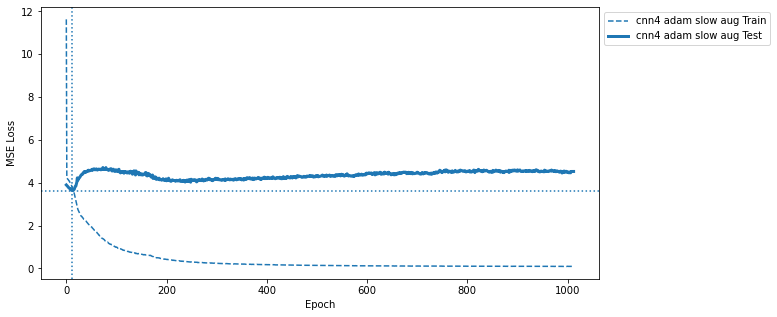

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn4 adam slow aug
val split
Running cnn4 adam slow aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 adam slow aug


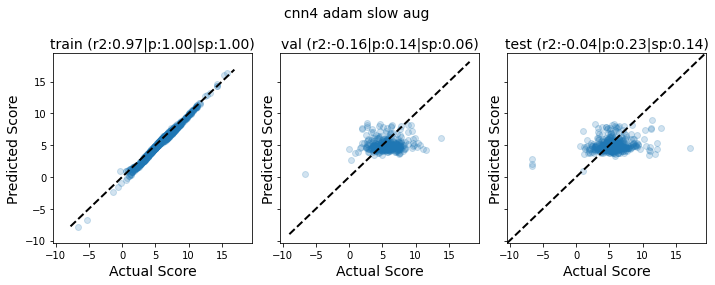

In [69]:
cnn4_name = 'cnn4 adam slow aug'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam
)

pred_dfs = parity_pred_by_split(cnn4_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:253 | train loss:0.495 | val loss: 4.355:   5%|▌         | 254/5000 [02:04<38:33,  2.05it/s]

EarlyStopping counter: 250 out of 1000


E:503 | train loss:0.434 | val loss: 4.221:  10%|█         | 504/5000 [04:07<36:48,  2.04it/s]

EarlyStopping counter: 500 out of 1000


E:753 | train loss:0.430 | val loss: 4.297:  15%|█▌        | 754/5000 [06:09<34:37,  2.04it/s]

EarlyStopping counter: 750 out of 1000


E:1003 | train loss:0.448 | val loss: 4.305:  20%|██        | 1003/5000 [08:12<32:43,  2.04it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


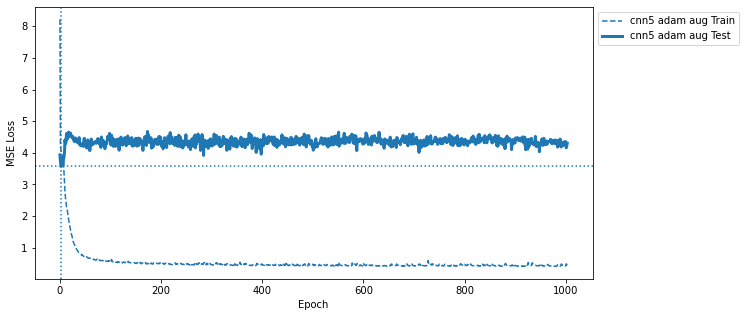

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn5 adam aug
val split
Running cnn5 adam aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn5 adam aug


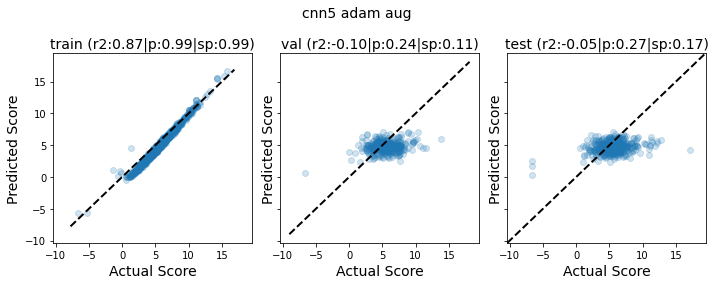

In [70]:
cnn5_name = 'cnn5 adam aug'
model_res[cnn5_name] = collect_model_stats(
    cnn5_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam
)

cnn5_pred_df = parity_pred_by_split(cnn5_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

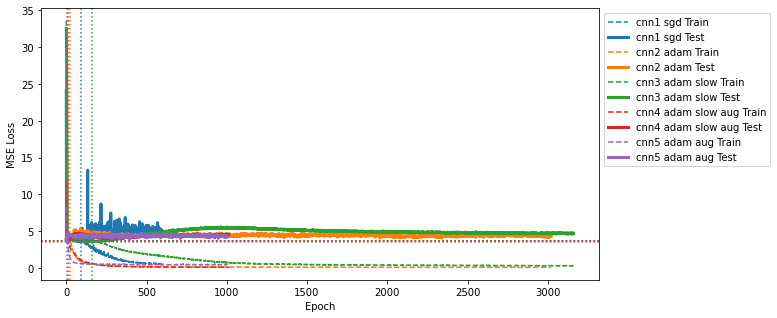

In [71]:
# tu.quick_loss_plot(
#     model_res[cnn1_name]['data_label']+\
#     model_res[cnn2_name]['data_label']+\
#     model_res[cnn3_name]['data_label']+\
#     model_res[cnn4_name]['data_label']+\
#     model_res[cnn5_name]['data_label'])

tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [75]:
line = pd.DataFrame({
    'truth': [-5, 15],
    'pred':  [-5, 15],
})

line_plot = alt.Chart(line).mark_line(color= 'black').encode(
    x= 'truth',
    y= 'pred',
)

v = cnn5_pred_df['val']
v['gene'] = v['locus_tag'].apply(lambda x: locus2info[x]['gene'])
v['product'] = v['locus_tag'].apply(lambda x: locus2info[x]['product'])
v['type'] = v['locus_tag'].apply(lambda x: locus2info[x]['type'])

chart = alt.Chart(v).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

chart + line_plot

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

alt.LayerChart(...)

In [76]:
t = cnn5_pred_df['test']
t['gene'] = t['locus_tag'].apply(lambda x: locus2info[x]['gene'])
t['product'] = t['locus_tag'].apply(lambda x: locus2info[x]['product'])
t['type'] = t['locus_tag'].apply(lambda x: locus2info[x]['type'])

chart = alt.Chart(t).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

chart + line_plot

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

alt.LayerChart(...)

## smaller models?

E:327 | train loss:4.241 | val loss: 3.916:   7%|▋         | 328/5000 [02:44<38:49,  2.01it/s]

EarlyStopping counter: 250 out of 1000


E:577 | train loss:4.241 | val loss: 3.916:  12%|█▏        | 578/5000 [04:49<36:51,  2.00it/s]

EarlyStopping counter: 500 out of 1000


E:827 | train loss:4.241 | val loss: 3.916:  17%|█▋        | 828/5000 [06:54<34:46,  2.00it/s]

EarlyStopping counter: 750 out of 1000


E:1077 | train loss:4.241 | val loss: 3.916:  22%|██▏       | 1077/5000 [08:58<32:43,  2.00it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


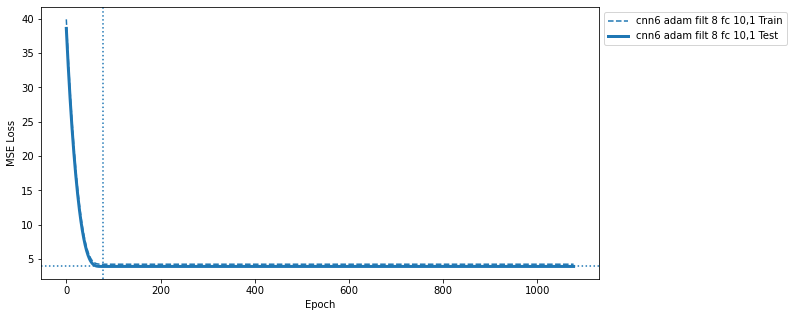

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/u

Running cnn6 adam filt 8 fc 10,1
val split
Running cnn6 adam filt 8 fc 10,1
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/u

Running cnn6 adam filt 8 fc 10,1


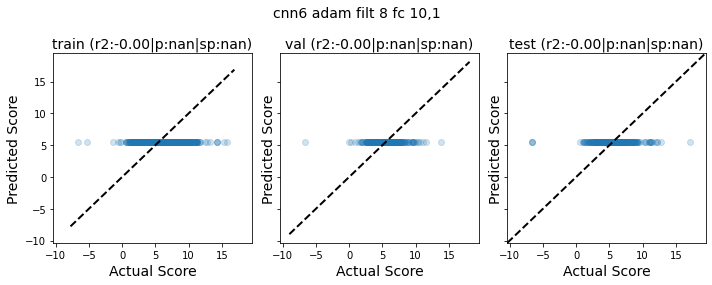

In [77]:
name = 'cnn6 adam filt 8 fc 10,1'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=8,
    num_filters2=8,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=1
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:254 | train loss:0.690 | val loss: 4.766:   5%|▌         | 255/5000 [02:35<48:26,  1.63it/s]

EarlyStopping counter: 250 out of 1000


E:504 | train loss:0.636 | val loss: 4.590:  10%|█         | 505/5000 [05:08<46:08,  1.62it/s]

EarlyStopping counter: 500 out of 1000


E:754 | train loss:0.615 | val loss: 4.626:  15%|█▌        | 755/5000 [07:41<43:05,  1.64it/s]

EarlyStopping counter: 750 out of 1000


E:1004 | train loss:0.615 | val loss: 4.465:  20%|██        | 1004/5000 [10:14<40:47,  1.63it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


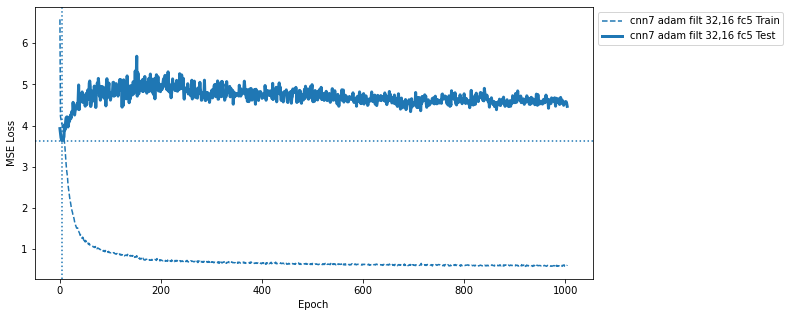

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn7 adam filt 32,16 fc5
val split
Running cnn7 adam filt 32,16 fc5
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn7 adam filt 32,16 fc5


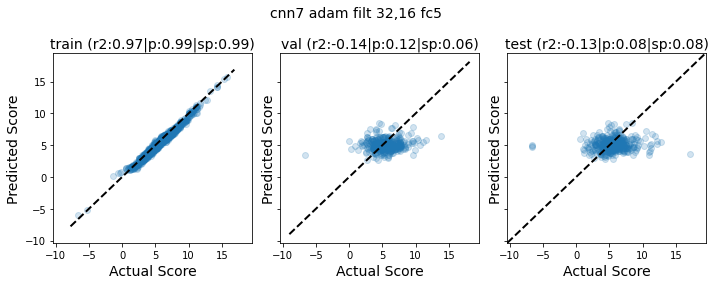

In [78]:
name = 'cnn7 adam filt 32,16 fc5'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=32,
    num_filters2=16,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

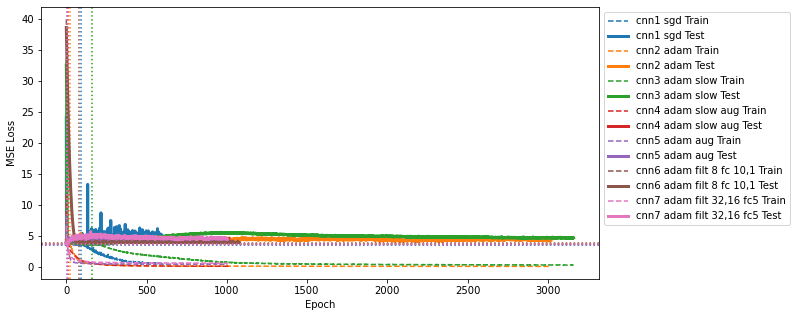

In [79]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

E:257 | train loss:1.991 | val loss: 4.086:   5%|▌         | 258/5000 [02:10<40:14,  1.96it/s]

EarlyStopping counter: 250 out of 1000


E:507 | train loss:1.883 | val loss: 3.861:  10%|█         | 508/5000 [04:18<37:51,  1.98it/s]

EarlyStopping counter: 500 out of 1000


E:757 | train loss:1.853 | val loss: 3.957:  15%|█▌        | 758/5000 [06:36<35:46,  1.98it/s]

EarlyStopping counter: 750 out of 1000


E:1007 | train loss:1.751 | val loss: 4.004:  20%|██        | 1007/5000 [09:05<36:03,  1.85it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


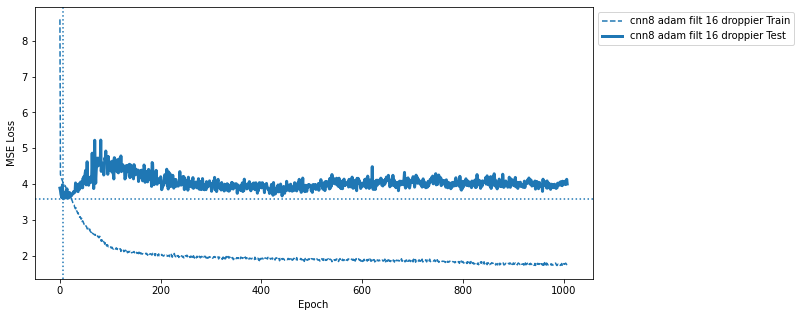

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn8 adam filt 16 droppier
val split
Running cnn8 adam filt 16 droppier
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam filt 16 droppier


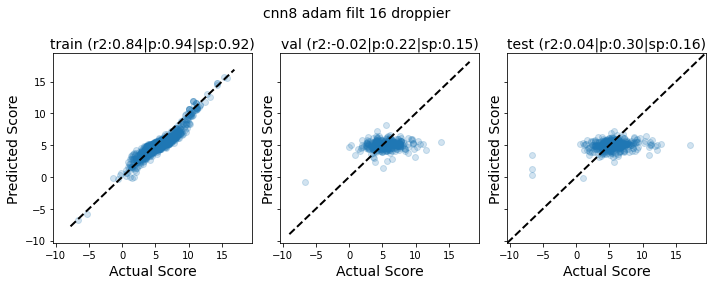

{'train':           locus_tag      truth       pred
 0     EQU24_RS00005   5.405936   5.110209
 1     EQU24_RS00010   6.122296   5.707951
 2     EQU24_RS00015   4.885784   4.645624
 3     EQU24_RS00035   6.387618   4.763341
 4     EQU24_RS00060   4.686595   5.082059
 ...             ...        ...        ...
 1767  EQU24_RS23145  11.118496  11.623544
 1768  EQU24_RS23155  11.113859  11.623544
 1769  EQU24_RS23165  11.125770  10.603828
 1770  EQU24_RS23170   5.311955   5.110948
 1771  EQU24_RS23175   2.446135   2.768844
 
 [1422 rows x 3 columns],
 'val':           locus_tag     truth      pred
 30    EQU24_RS00400  5.282882  5.201600
 31    EQU24_RS00405  6.669704  5.295234
 36    EQU24_RS00490  7.274688  4.828070
 38    EQU24_RS00500  6.135796  5.822767
 41    EQU24_RS00595  8.320454  4.501546
 ...             ...       ...       ...
 1742  EQU24_RS22755  6.181057  6.667754
 1744  EQU24_RS22785  1.857495  5.783386
 1754  EQU24_RS22955  3.606959  4.301890
 1756  EQU24_RS23000 -6.643856

In [81]:
name = 'cnn8 adam filt 16 droppier'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=16,
    num_filters2=16,
    conv_pool_size1=3,
    dropout1=0.4,
    dropout2=0.4,
    
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn8 adam filt 16 droppier
val split
Running cnn8 adam filt 16 droppier
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam filt 16 droppier


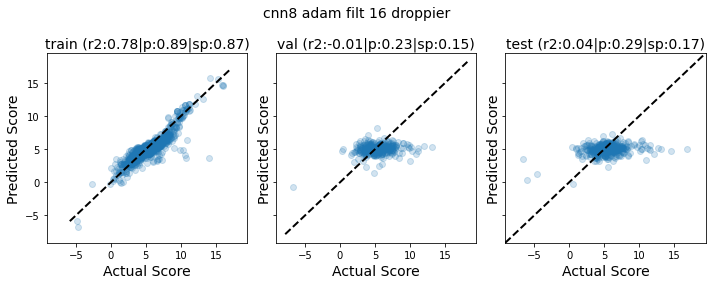

In [83]:
# THIs should be wrong... what does it look like?
pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='NoCu',
                     splits=['train','val','test']
                    )

# NOW, let's do this again with shuffled seqs